# <img src="https://raw.githubusercontent.com/inlab-geo/cofi/main/docs/source/_static/latte_art_cropped.png" width="5%" style="vertical-align:bottom"/> Workshop Notebook 3 (ERT)

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/inlab-workshop/blob/main/notebooks/3_electrical_resistivity_tomography.ipynb)

---

## What we do in this notebook

Here we look at applying CoFI to an electrical resistivity tomography problem,
and explore different iterative non linear solvers.

---

## Learning outcomes

- A demonstration of CoFI's ability to interface with a mature package to solve the ERT forward problem
- An exposé of CoFI's ability to interface with the iterative non-linear solvers in `scipy.optimize`
- An illustration of how CoFI can be used to identify the most appopriate iterative non-linear solver for a given problem



In [1]:
# Environment setup (uncomment code lines below)

# !git clone https://github.com/inlab-geo/inlab-workshop.git
# %cd inlab-workshop/notebooks/

# !pip install -U cofi cofi-espresso

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

# Problem description


Electrical resistivity tomography is the inversion of measurements of apparent electrical resistivties measured between electrodes placed at the surface. Its applications include the detection and delination of groundwater resources, clay formations and the monitoring pollution plumes.

Here we illustrate the expandability of CoFI by combining a mature Python library for geophysical inversion that implements one inversion method for ERT (PyGIMLI https://www.pygimli.org/) with the iterative non linear solvers we have made available in CoFI. In the following the forward problem will be solved using PyGIMLI while the inverse problem will be solved using CoFI.

The objective function we are minimizing is given as

$
\Psi(\mathbf{m}) = (\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} C_{d}^{-1}(\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} + \lambda \mathbf{m}^{T} W^{\mathrm{T}} W \mathbf{{m}}
$

where $d$ represents the data vector of measured apparent resistivties, $\mathrm{f}(\mathbf{m})$ is the model prediction, $C_d^{-1}$ is the inverse of the data covariance matrix, $W$ the model smoothing matrix and $\mathbf{m}$ the model vector and $\lambda$ a regularization factor. 

The model update is then given as

$
\begin{equation} \Delta \mathbf{m}= (\underbrace{\mathbf{J}^T \mathbf{C}_d^{-1} \mathbf{J}+\lambda W^{T} W}_{\mathbf{Hessian}})^{-1}
(\underbrace{ \mathbf{J}^T\mathbf{C}_d^{-1} 
(\mathbf{d}-\mathrm{f}(\mathbf{m}))+\lambda W^{T} W \mathbf{m}}_{\mathbf{Gradient}}),
\end{equation} 
$

where $J$ represents the Jacobian.

Successful inversion also relies on the objective function being smooth and predictable for apparent resistivty data. It is advantageous to convert measurements and mdoel parameters to scale logarithmically to obtain a smoother and more predictable objective function when compared with using the unscaled data and unscaled mode parameters.


#### Further reading

- Rücker, C., Günther, T., & Spitzer, K. (2006). Three-dimensional modelling and inversion of dc resistivity data incorporating topography – I. Modelling. Geophys. J. Int, 166, 495–505. https://doi.org/10.1111/j.1365-246X.2006.03010.x
- Günther, T., Rücker, C., & Spitzer, K. (2006). Three-dimensional modelling and inversion of dc resistivity data incorporating topography - II. Inversion. Geophysical Journal International, 166(2), 506–517. https://doi.org/10.1111/J.1365-246X.2006.03011.X
- Wheelock, B., Constable, S., & Key, K. (2015). The advantages of logarithmically scaled data for electromagnetic inversion. Geophysical Journal International, 201(3), 1765–1780. https://doi.org/10.1093/GJI/GGV107


## Interfacing to PyGIMLi

PyGIMLi provides all the functionality to compute the apparent resistivities and Jacobian given a model as well as to invert the data. One of our goals around CoFI is to *never to reinvent the wheel* thus in the following we will
- rely on PyGIMLi's functionality to plot the model and data; and
- use PyGIMLi's capabilities to compute the response and the Jacobian from a model

To achieve this we first define a set of utility functions that will facilitate interfacing to PyGIMLi. We will alsow show how CoFI can directly interface with a mature package without the need to go via [Espresso](https://cofi-espresso.readthedocs.io/en/latest/). 

PyGIMLi uses different meshes and can provides adaptive meshing capabilities via gmsh https://gmsh.info/, all CoFI needs to access is the model vector, the Jacobian, the regularization matrix and the model prediction. This makes for a minimal interface.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli
from pygimli.physics import ert
from pygimli import meshtools

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

In [3]:
############# Utility functions using PyGIMLi ##############################################

# inversion mesh bound
x_inv_start = -5
x_inv_stop = 55
y_inv_start = -20
y_inv_stop = 0
x_invmesh = np.linspace(start=x_inv_start, stop=x_inv_stop, num=40)
y_invmesh = np.linspace(start=y_inv_start,stop=y_inv_stop,num=10)

# Dipole Dipole (dd) measuring scheme
def survey_scheme(start=0, stop=50, num=51, schemeName="dd"):
    scheme = ert.createData(elecs=np.linspace(start=start, stop=stop, num=num),schemeName=schemeName)
    return scheme

# true geometry, forward mesh and true model
def model_true(scheme, start=[-55, 0], end=[105, -80], anomaly_pos=[10,-7], anomaly_rad=5):
    world = meshtools.createWorld(start=start, end=end, worldMarker=True)
    for s in scheme.sensors():          # local refinement 
        world.createNode(s + [0.0, -0.1])
    conductive_anomaly = meshtools.createCircle(pos=anomaly_pos, radius=anomaly_rad, marker=2)
    geom = world + conductive_anomaly
    rhomap = [[1, 200], [2,  50],]
    mesh = meshtools.createMesh(geom, quality=33)
    return mesh, rhomap

# PyGIMLi ert.ERTManager
def ert_manager(data, verbose=False):
    return ert.ERTManager(data, verbose=verbose, useBert=True)

# inversion mesh
def inversion_mesh(ert_mgr):
    inv_mesh = ert_mgr.createMesh(ert_mgr.data)
    # print("model size", inv_mesh.cellCount())   # 1031
    ert_mgr.setMesh(inv_mesh)
    return inv_mesh

# inversion mesh rectangular (the above is by default triangular)
def inversion_mesh_rect(ert_manager):
    inv_mesh = pygimli.createGrid(x=x_invmesh, y=y_invmesh, marker=2)
    inv_mesh = pygimli.meshtools.appendTriangleBoundary(inv_mesh, marker=1, xbound=50, ybound=50)
    # print("model size", inv_mesh.cellCount())    # 1213
    ert_manager.setMesh(inv_mesh)
    return inv_mesh

# PyGIMLi ert.ERTModelling
def ert_forward_operator(ert_manager, scheme, inv_mesh):
    forward_operator = ert_manager.fop
    forward_operator.setComplex(False)
    forward_operator.setData(scheme)
    forward_operator.setMesh(inv_mesh, ignoreRegionManager=True)
    return forward_operator

# regularization matrix
def reg_matrix(forward_oprt):
    region_manager = forward_oprt.regionManager()
    region_manager.setConstraintType(2)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

# initialise model
def starting_model(ert_mgr, val=None):
    data = ert_mgr.data
    start_val = val if val else np.median(data['rhoa'].array())     # this is how pygimli initialises
    start_model = np.ones(ert_mgr.paraDomain.cellCount()) * start_val
    start_val_log = np.log(start_val)
    start_model_log = np.ones(ert_mgr.paraDomain.cellCount()) * start_val_log
    return start_model, start_model_log

# convert model to numpy array
def model_vec(rhomap, fmesh):
    model_true = pygimli.solver.parseArgToArray(rhomap, fmesh.cellCount(), fmesh)
    return model_true


Our example is centred around inverting dipole dipole measurements of apparent resistivites in 2D with a circular shaped low resistivtiy anomaly. 

#### Further reading

https://www.agiusa.com/dipole-dipole%E2%80%8B-%E2%80%8Barray%E2%80%8B

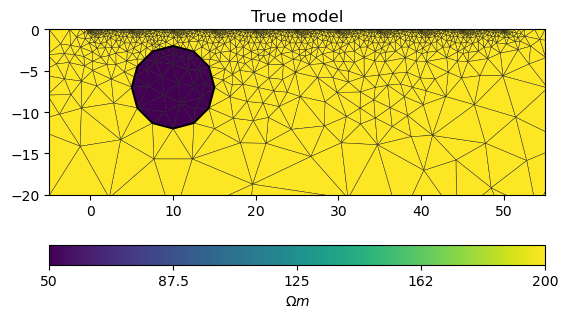

In [4]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_xlim(x_inv_start, x_inv_stop)
ax[0].set_ylim(y_inv_start, y_inv_stop)
ax[0].set_title("True model");

The model response for the true model has been previously computed with PyGIMLi and noise has been added with the magnitude of the noise depending on the dipole dipole separation.

In [5]:
# load data and covariance matrix
log_data = np.loadtxt("ert_data_log.txt")
data_cov_inv = np.loadtxt("ert_data_cov_inv.txt")

# create PyGIMLi's ERT manager
ert_mgr = ert_manager("ert_data.dat")

Text(0.5, 1.0, 'Provided data')

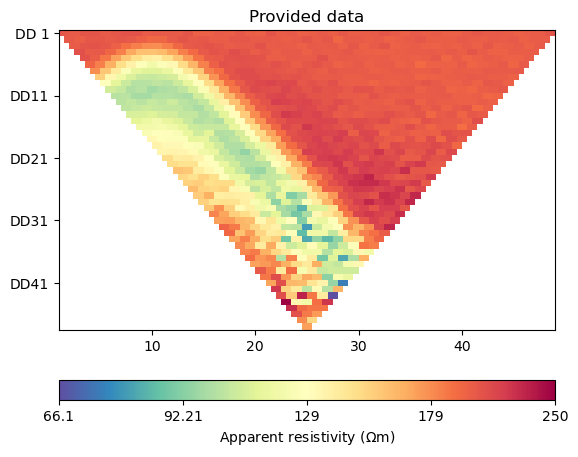

In [6]:
# plot data
data = ert_mgr.data
ax = ert.show(data)
ax[0].set_title("Provided data")

PyGIMLi solves the ERT forward problem accurately and efficiently by defining boundary cells or ghost cells around the region of interest and creating an optimal triangular mesh. This is all handled by PyGIMLi and the model vector for the purpose of the inversion ared the cells plotted in yellow.

27/10/22 - 13:18:03 - pyGIMLi - INFO - Found 2 regions.
27/10/22 - 13:18:03 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

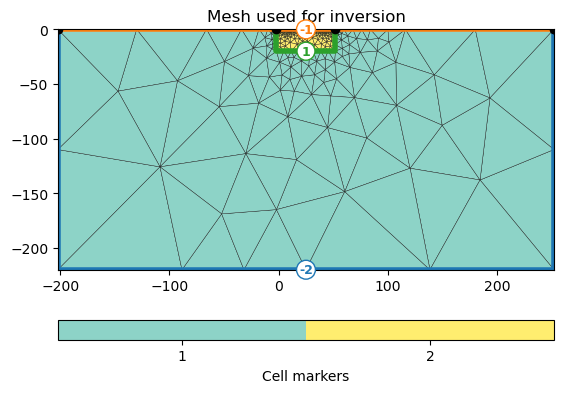

In [7]:
inv_mesh = inversion_mesh(ert_mgr)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

27/10/22 - 13:18:04 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
27/10/22 - 13:18:04 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
27/10/22 - 13:18:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/10/22 - 13:18:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

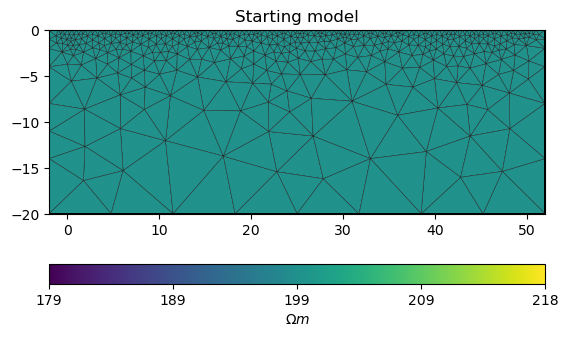

In [8]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_mgr, scheme, inv_mesh)

# extract regularisation matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log = starting_model(ert_mgr)
ax = pygimli.show(ert_mgr.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

The next step is to define the functions for CoFI. Typically a given solver will only require a subset of the functions we define in the following but in this example we would like to explore a wide range of solvers.

In [9]:
############# Functions provided to CoFI ##############################################

## Note: all functions below assume the model in log space!

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

def get_response(model, forward_operator):
    model = _ensure_numpy(model)
    return np.log(np.array(forward_operator.response(np.exp(model))))

def get_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    return residual

def get_jacobian(model, forward_operator):
    response = get_response(model, forward_operator)
    model = _ensure_numpy(model)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac

def get_jac_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    model = _ensure_numpy(model)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac, residual

def get_data_misfit(model, log_data, forward_operator, data_cov_inv=None):
    residual = get_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    return np.abs(residual.T @ data_cov_inv @ residual)

def get_regularization(model, Wm, lamda):
    model = _ensure_numpy(model)
    model = np.exp(model)
    return lamda * (Wm @ model).T @ (Wm @ model)

def get_objective(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    data_misfit = get_data_misfit(model, log_data, forward_operator, data_cov_inv)
    regularization = get_regularization(model, Wm, lamda)
    obj = data_misfit + regularization
    return obj

def get_gradient(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac, residual = get_jac_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    data_misfit_grad =  - residual.T @ data_cov_inv @ jac
    regularization_grad = lamda * Wm.T @ Wm @ np.exp(model)
    return data_misfit_grad + regularization_grad

def get_hessian(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac = get_jacobian(model, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    hess = jac.T @ data_cov_inv @ jac + lamda * Wm.T @ Wm
    return hess

As in the traveltime tomography example, we now use these functions to define our `BaseProblem`.

In [10]:
# hyperparameters
lamda = 0.0001

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt, data_cov_inv])
ert_problem.set_regularization(get_regularization, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_initial_model(start_model_log)

With the `BaseProblem` defined, we can ask CoFI to list the solver libraries we can use for our problem.

In [11]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "cofi.simple_newton"
    ],
    "sampling": []
}


From the traveltime tomography example we know that the `cofi.simple_newton` solver worked well so we will try it.

# Newton Step

The Jacobian and Hessian are only local measures of the first and second derivative of the objective function. And given the ERT inverse problem is non-linear, we can no longer take the full Newton Step to compute a model update. In practice:

- If the step length is chosen too large we may end up with a model that is non-physical and the forward solver will crash and/or we will overshoot.
- If the step size is chosen too small too many iterations might be needed to reach convergence

27/10/22 - 13:18:04 - Core - WARNING -  data contains no K-factors but we calculate them  analytically for the response call


Iteration #0, objective function value: 229.71418345445022
Iteration #1, objective function value: 224.79875151411954
Iteration #2, objective function value: 220.36237268797797
Iteration #3, objective function value: 215.90570020911184
Iteration #4, objective function value: 211.61775613255452
Iteration #5, objective function value: 207.3825693018691
Iteration #6, objective function value: 203.263958279641
Iteration #7, objective function value: 199.21577271919293
Iteration #8, objective function value: 195.26522476018053
Iteration #9, objective function value: 191.38884081936882

Number of objective function evaluations: 10
Number of gradient function evaluations: 10
Number of hessian function evaluations: 10


Text(0.5, 1.0, 'Provided data')

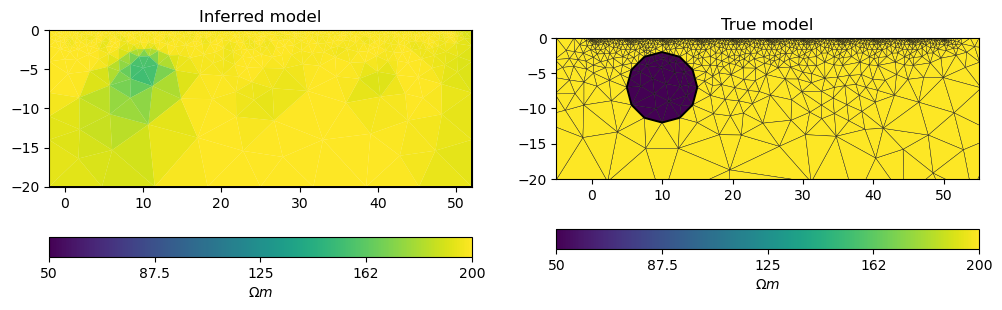

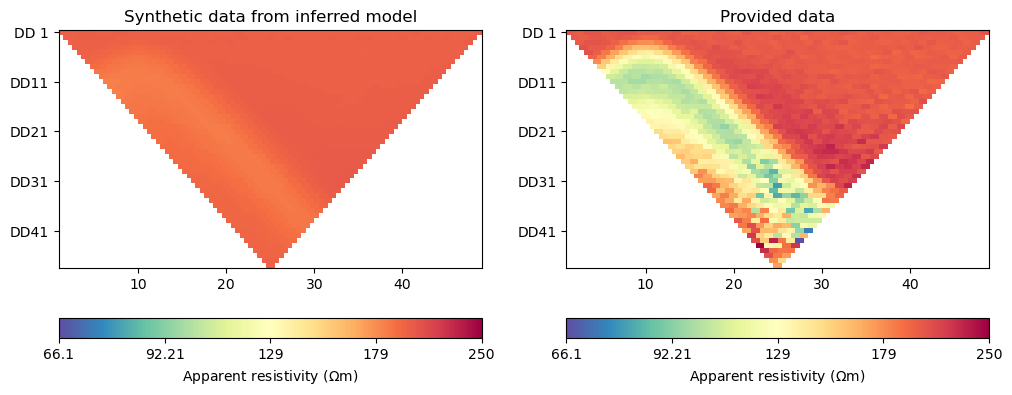

In [12]:
inv_options_newton = InversionOptions()
inv_options_newton.set_tool("cofi.simple_newton")
inv_options_newton.set_params(max_iterations=10, step_length=0.01)

inv = Inversion(ert_problem, inv_options_newton)
inv_result = inv.run()
# inv_result.summary()
print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")
print(f"Number of hessian function evaluations: {inv_result.n_hess_evaluations}")

# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0], cMax=rhomap[0][1], cMin=rhomap[1][1])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_xlim(x_inv_start, x_inv_stop)
axes[1].set_ylim(y_inv_start, y_inv_stop)
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")

### Convergence of Newton's Method
A simple illustrative example of the limitations around Newton's method is finding the minimum of the following non-convex function:

$f(x) = x^3 − 2x + 2$, with $\nabla f(x) = 3x^2 -2$ and $H_f(x) = 6 x $

If we start with $x=0$ the result will oscilate between 0 and 1 and never converge to the correct solution of $x\approx -1.77$


In [13]:
import scipy
x0=0.1
scipy.optimize.newton(lambda x: x**3-2*x+2, x0, fprime=lambda x: 3 * x**2-2,
                       fprime2=lambda x: 6 * x,full_output=True, disp=True,maxiter=51)

(-1.7692923542386314,
       converged: True
            flag: 'converged'
  function_calls: 39
      iterations: 13
            root: -1.7692923542386314)

PyGIMLi uses a line search to determine the optimal step length, that means the descent direction is given by the full Newton Step with the length adjusted so that it doesn't overshoot and results in an improvment of the fit to the data. The major alternative to employing a line search is to employ a trust region method. Trust regions methods try to estimate the region around the current model within which the assumption of local linearity holds and then limit the model update to stay within that region. 


### Further reading

https://medium.com/intro-to-artificial-intelligence/line-search-and-trust-region-optimisation-strategies-638a4a7490ca

## Workshop challenge:

CoFI provides access to more sophisticated solvers that are available in 
- `scipy.optimize.minimize` https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
- `torch.optim` https://pytorch.org/docs/stable/optim.html#algorithms

For practical application we are interested in a solver that converges  with the fewest calls to the forward problem to a model that is acceptablly close to the true model and explains the data. The consequence of employing a line search or trust region method or more broadly any method seeking to find the optimal step length is that additional calls to a forward problem need to be made to determine the optimal step length and different approaches require different numbers of calls to the forward problem depending on the shape of the objective function.


1) Which of the following solvers from `scipy.optimize.minimize` results in an acceptable model with the fewest calls to the forward solver to compute the model response and to the forward solver to compute the Jacobian?    
  - "newton-cg" - https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html
  - "dogleg" - https://docs.scipy.org/doc/scipy/reference/optimize.minimize-dogleg.html
  - "trust-ncg"- https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustncg.html

2) Try and find a suitable algorithm and hyperparameters settings from `torch.optim`. Some suggested algorithms include:
  - TODO
  - TODO

Iteration #1
  objective value: 69.41232753902358
Iteration #2
  model change: 1.9521920346073645
  objective value: 32.31371502955868
Iteration #3
  model change: 2.00500050501124
  objective value: 31.171940388084867
Iteration #4
  model change: 0.37747947597238996
  objective value: 27.460445378249585
Iteration #5
  model change: 1.2758048179587191
  objective value: 17.691012543494743
Iteration #6
  model change: 0.36975375753519363
  objective value: 13.707069626159713
Iteration #7
  model change: 0.2278464702539639
  objective value: 11.47155839527201
Iteration #8
  model change: 0.7119892706126505
  objective value: 10.779768258980473
Iteration #9
  model change: 0.24671253819187977
  objective value: 9.618581002649401
Iteration #10
  model change: 0.1902053798830444
  objective value: 8.486752716367635

Number of objective function evaluations: 98
Number of gradient function evaluations: 98
Number of hessian function evaluations: 10


Text(0.5, 1.0, 'Provided data')

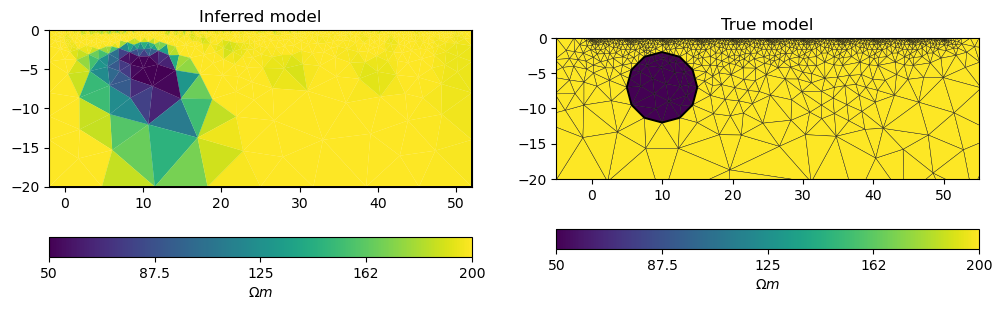

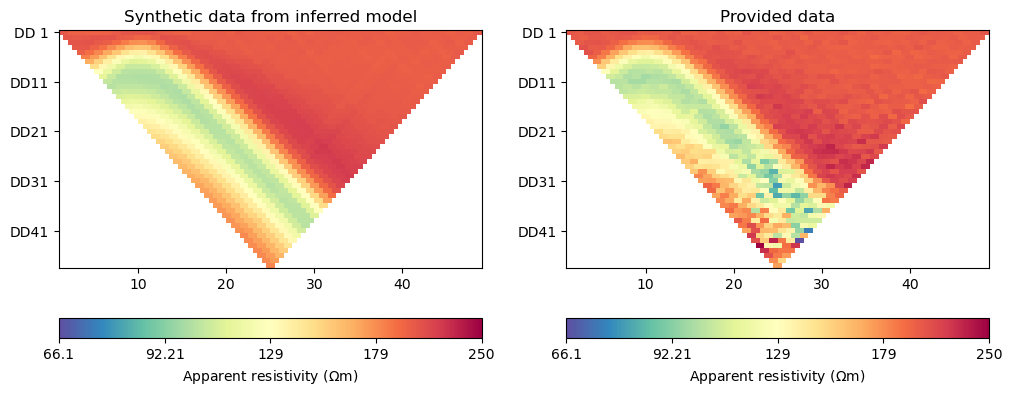

In [14]:
#@title scipy.optimize.minimize 'newton-cg' 
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="newton-cg", options={"maxiter": 10})

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1
    
inv_options_scipy.set_params(callback=CallbackFunction())

inv_options_scipy.set_params(callback=CallbackFunction())

inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
#print(f"\nSolver message: {inv_result.message}")
print(f"\nNumber of objective function evaluations: {inv_result.nfev}")
print(f"Number of gradient function evaluations: {inv_result.njev}")
print(f"Number of hessian function evaluations: {inv_result.nhev}")

# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model

pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0], cMax=rhomap[0][1], cMin=rhomap[1][1])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_xlim(x_inv_start, x_inv_stop)
axes[1].set_ylim(y_inv_start, y_inv_stop)
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")


Iteration #1
  objective value: 157.50708172346378
Iteration #2
  model change: 2.0
  objective value: 68.94013122104023
Iteration #3
  model change: 3.9999999999999996
  objective value: 34.90264090871146
Iteration #4
  model change: 0.0
  objective value: 34.90264090871146
Iteration #5
  model change: 2.0000000000000004
  objective value: 22.81471892059869
Iteration #6
  model change: 0.0
  objective value: 22.81471892059869
Iteration #7
  model change: 1.0
  objective value: 17.906047674756266
Iteration #8
  model change: 0.0
  objective value: 17.906047674756266
Iteration #9
  model change: 0.5
  objective value: 16.90900098786149
Iteration #10
  model change: 0.0
  objective value: 16.90900098786149

Number of objective function evaluations: 11
Number of gradient function evaluations: 7
Number of hessian function evaluations: 7


Text(0.5, 1.0, 'Provided data')

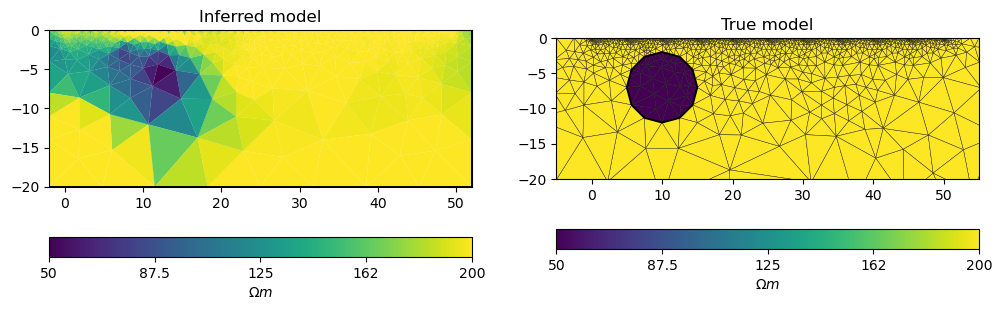

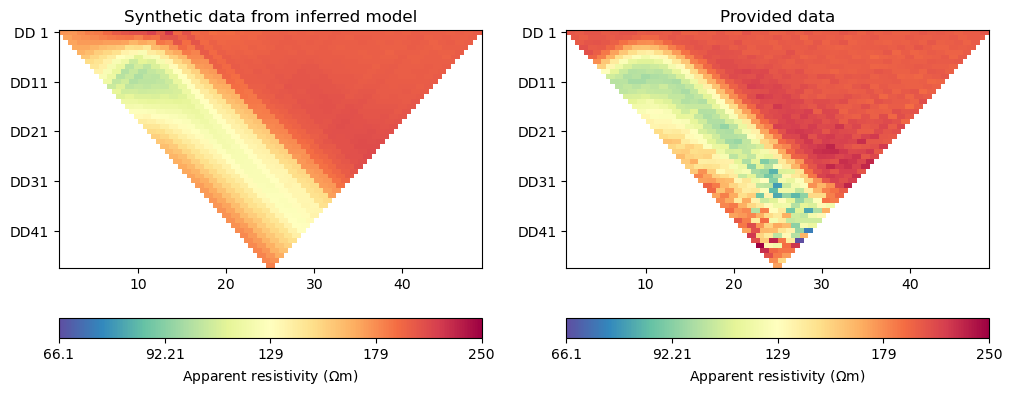

In [15]:
#@title scipy.optimize.minimize 'dogleg' 
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="dogleg", options={"maxiter": 10})

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1
    
inv_options_scipy.set_params(callback=CallbackFunction())

inv_options_scipy.set_params(callback=CallbackFunction())

inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
print(f"\nNumber of objective function evaluations: {inv_result.nfev}")
print(f"Number of gradient function evaluations: {inv_result.njev}")
print(f"Number of hessian function evaluations: {inv_result.nhev}")

# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0], cMax=rhomap[0][1], cMin=rhomap[1][1])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_xlim(x_inv_start, x_inv_stop)
axes[1].set_ylim(y_inv_start, y_inv_stop)
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")


Iteration #1
  objective value: 157.50708172346378
Iteration #2
  model change: 2.0
  objective value: 68.94013122104028
Iteration #3
  model change: 2.088598198678278
  objective value: 51.74447637862966
Iteration #4
  model change: 2.235768382076769
  objective value: 32.60775764541545
Iteration #5
  model change: 1.7295706120934409
  objective value: 29.213175185113155
Iteration #6
  model change: 0.0
  objective value: 29.213175185113155
Iteration #7
  model change: 1.000000000004815
  objective value: 16.60616355310069
Iteration #8
  model change: 0.0
  objective value: 16.60616355310069
Iteration #9
  model change: 0.4999999999999974
  objective value: 11.968202845280034
Iteration #10
  model change: 0.0
  objective value: 11.968202845280034

Number of objective function evaluations: 11
Number of gradient function evaluations: 11
Number of hessian function evaluations: 63


Text(0.5, 1.0, 'Provided data')

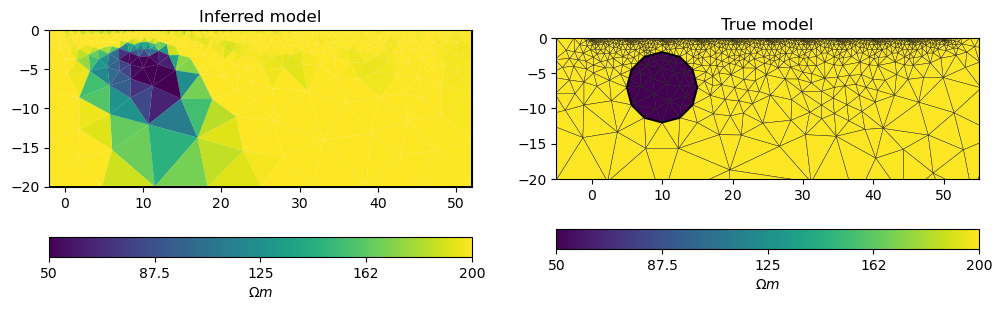

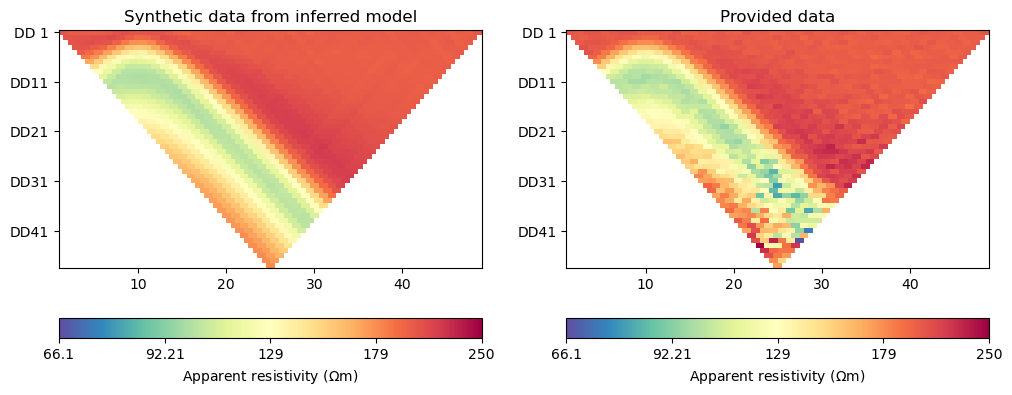

In [16]:
#@title scipy.optimize.minimize 'trust-krylov' 
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-krylov", options={"maxiter": 10})

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1
    
inv_options_scipy.set_params(callback=CallbackFunction())

inv_options_scipy.set_params(callback=CallbackFunction())

inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
print(f"\nNumber of objective function evaluations: {inv_result.nfev}")
print(f"Number of gradient function evaluations: {inv_result.njev}")
print(f"Number of hessian function evaluations: {inv_result.nhev}")

# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0], cMax=rhomap[0][1], cMin=rhomap[1][1])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_xlim(x_inv_start, x_inv_stop)
axes[1].set_ylim(y_inv_start, y_inv_stop)
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")


Iteration #0, objective value: 229.71418345445022
Iteration #1, objective value: 60.28643050154074
Iteration #2, objective value: 104.27525767618125
Iteration #3, objective value: 123.66476301973928
Iteration #4, objective value: 92.59637469557536
Iteration #5, objective value: 58.119212046430846
Iteration #6, objective value: 57.823002578945115
Iteration #7, objective value: 57.33729890486397
Iteration #8, objective value: 56.674783015414256
Iteration #9, objective value: 55.84987132337467
Iteration #10, objective value: 54.87985770643878
Iteration #11, objective value: 53.788434943516876
Iteration #12, objective value: 52.607646496981445
Iteration #13, objective value: 51.377960480584996
Iteration #14, objective value: 50.14334423091819
Iteration #15, objective value: 48.94371130144435
Iteration #16, objective value: 47.80714245614948
Iteration #17, objective value: 46.747642637851214
Iteration #18, objective value: 45.771690643844885
Iteration #19, objective value: 44.8857708855458


Text(0.5, 1.0, 'Provided data')

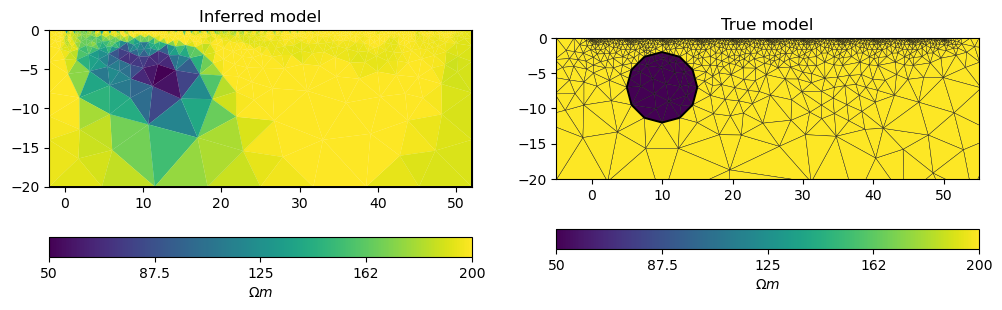

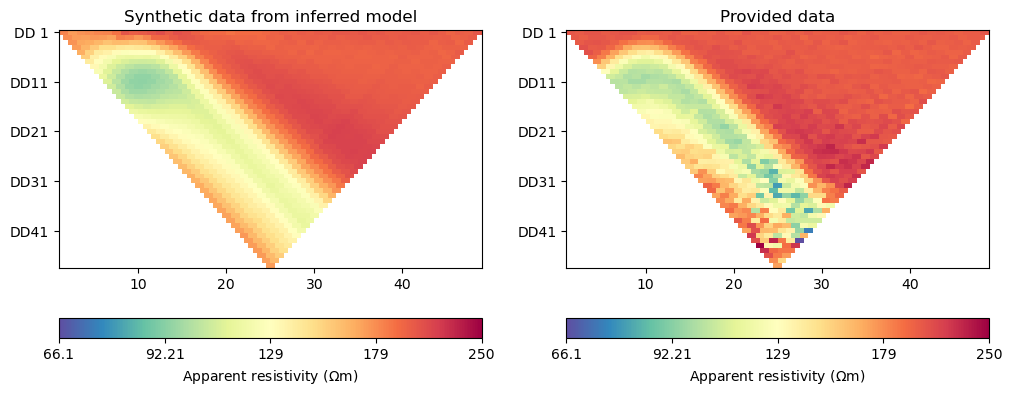

In [17]:
#@title torch.optim 'RAdam' 
inv_options_torch = InversionOptions()
inv_options_torch.set_tool("torch.optim")
inv_options_torch.set_params(algorithm="RAdam", lr=0.1, num_iterations=20, verbose=True)

inv = Inversion(ert_problem, inv_options_torch)
inv_result = inv.run()
# inv_result.summary()
print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")

# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0], cMax=rhomap[0][1], cMin=rhomap[1][1])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_xlim(x_inv_start, x_inv_stop)
axes[1].set_ylim(y_inv_start, y_inv_stop)
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")

# A word about convergence criteria...

We have run each solver for a predetermined number of iterations and the rate at which the value of the objective function decreased was different for the different solver. Typically, iterative non-linear algorithms terminate their iterations when a predefined fit to the data, minimun update to the model or increase in fit to the data is achieved between subsequent iterations.


# Conversation starters

- What other optimizer library would you like to see added to CoFI?
- What other mature forward solvers would you like to see interfaced with CoFI?



## Watermark

In [18]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev21
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
